In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

100.0%Files already downloaded and verified


In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ../Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [6]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [7]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [    9     5     2     3     0     5     9     5     1     6]
Class:  truck   dog  bird   cat plane   dog truck   dog   car  frog


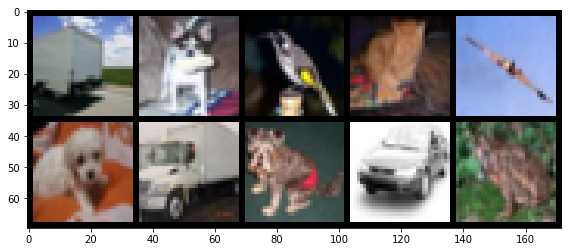

In [8]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [9]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [10]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    

In [12]:
count_parameters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
______
 81302


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.70864832  accuracy:  26.690%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.97483790  accuracy:  32.445%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.26065183  accuracy:  36.177%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.19347298  accuracy:  38.752%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.33882332  accuracy:  40.588%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 0.88744813  accuracy:  50.570%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.36801720  accuracy:  50.915%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.14745879  accuracy:  51.540%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 2.16786027  accuracy:  52.310%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.06422019  accuracy:  52.852%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.00972402  accuracy:  57.180%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.85996133  accuracy:  56.850%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.04415560  accuracy:  57.057%
epoch:  2  b